In [1]:

# mark in Kale as skip
! pip3 install --upgrade pip
! pip3 install pendulum==2.1.2
! pip3 install pandas==1.4.4
! pip3 install matplotlib==3.3.4
! pip3 install --upgrade tensorflow==2.11.0


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.7 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.0/490.0 kB 25.0 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 57.0 MB/s eta 0:00:00
     ━━━

In [2]:
# mark in Kale as skip
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)


In [6]:

# mark in katib as imports
import pendulum
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, BatchNormalization, Lambda
from tensorflow.keras.regularizers import l1,l2, L1L2
import matplotlib.pyplot as plt
from scipy import stats


In [14]:
# Set time in the pipeline parameters and in Katib (as string and the only value) to the output of this
pendulum.now(tz='America/New_York').__str__()[:16].replace('T','').replace(':','').replace('_','-')

'2023-01-051310'

In [8]:
# mark in Kayle as pipeline parameters
data_file_to_run = "IMP_height.txt"

experiment_description = "Soy Height GWAS"

learning_rate = 0.001 # 0.0001957
conv_1_dropout_rate = 0.50 # Dropout rate for first convolutional layer
conv_1_kernel_l1 = 0.2 # L1 and l2 regularization for the first conv1d layer's weights
conv_1_kernel_l2 = 0.6
conv_1_bias_l2 = 0.6 # L1 and l2 regularization for the first conv1d layer's bias
conv_1_activity_l2 = 0.00001 # L1 and l2 activity  regularization for the first conv1d layer

conv_x_kernel_l1 = 0.3
conv_x_kernel_l2 = 0.3
conv_x_bias_l2 = 0.6
conv_x_activity_l2 = 0.0001

dense_x_kernel_l1 = 0.3
dense_x_kernel_l2 = 0.6
dense_x_bias_l2 = 0.0001
dense_x_activity_l2 = 0.0001

dense_out_kernel_l1 = 0.1
dense_out_kernel_l2 = 0.6
dense_out_bias_l2 = 0.6
dense_out_activity_l2 = 0.00001

conv_initializer = 'TruncatedNormal'  #    # 'TruncatedNormal' 'glorot_uniform'  "GlorotNormal",  "HeNormal" 'random_normal'  
dese_initializer = "GlorotNormal" # 'TruncatedNormal' # "GlorotUniform"

dropout_rate = 0.151
num_dense_layers = 3
num_dense_units = 20

conv_activation = "elu" # "linear"
activation = "elu"
loss = 'huber_loss' # 'mean_squared_error' 'mean_absolute_error'

final_activation_scale_factor = 3.5

batch_size = 30
epochs = 2

time = '2023-01-051310'


In [4]:
# mark in Kayle as pipeline step: "preprocessing": Depends on none

ht = pd.read_csv(data_file_to_run, sep = '\t')
ht_pd = ht_relevant_cols = ht.drop(columns = ['strain', 'height', 'folds'])
phenotypes_norm = ht_pd.pop("norm_phe")
for col in ht_pd.columns:
    ht_pd[col] = ht_pd[col].astype('category')
ohe_height_genotypes = pd.get_dummies(ht_pd)

def train_test_splitting(row, split_ratio):
    string_of_row = "".join([str(l) for l in list(row.values)])
    return (abs(hash(string_of_row)) % 10) / 10 < split_ratio
belongs_in_train_set_index =\
    np.array([train_test_splitting(ohe_height_genotypes.loc[i],0.7)
     for i in np.arange(ht_pd.shape[0])])

train_ohe_height_genotypes = ohe_height_genotypes[belongs_in_train_set_index]
val_ohe_height_genotypes = ohe_height_genotypes[~belongs_in_train_set_index]

train_phenotypes_norm = phenotypes_norm[belongs_in_train_set_index]
val_phenotypes_norm = phenotypes_norm[~belongs_in_train_set_index]

# Make sure the number of rows in test and train add up to the original rows
assert train_ohe_height_genotypes.shape[0] + val_ohe_height_genotypes.shape[0] == ht_pd.shape[0]

# Data as a numpy array...
train_ohe_height_genotypes_np = train_ohe_height_genotypes.values
val_ohe_height_genotypes_np = val_ohe_height_genotypes.values

train_phenotypes_norm_np = train_phenotypes_norm.values
val_phenotypes_norm_np = val_phenotypes_norm.values

# Reshape to fit the conv1D network. 
train_np_ohe_reshaped_for_conv_1_d =\
    train_ohe_height_genotypes_np.reshape((train_ohe_height_genotypes_np.shape[0],
                                          train_ohe_height_genotypes_np.shape[1], 1))
val_np_ohe_reshaped_for_conv_1_d =\
    val_ohe_height_genotypes_np.reshape((val_ohe_height_genotypes_np.shape[0],
                                        val_ohe_height_genotypes_np.shape[1],1))

np.save('train_data_ready', train_np_ohe_reshaped_for_conv_1_d)
np.save('val_data_ready', val_np_ohe_reshaped_for_conv_1_d)
np.save('train_labels_ready', train_phenotypes_norm_np)
np.save('val_labels_ready',val_phenotypes_norm_np)

# Since the data was reshaped for the convolutional 1D neural network, we are also saving the 
# non-reshaped data to be used for calculating saliency.

np.save("val_snps_for_saliency", val_ohe_height_genotypes_np)

print("Preprocessing successful")


Preprocessing successful


In [41]:
# mark in Kayle as pipeline step "train": depends on "data-preprocessing"
nb_classes = 3

data_files = ['./train_data_ready.npy',
              "./val_data_ready.npy",
              "./train_labels_ready.npy",
              "./val_labels_ready.npy"]
# artifact_bucket_root_name = artifacts_bucket.split('/')[-1]
# print(artifact_bucket_root_name)
# storage_client = storage.Client()
# bucket = storage_client.get_bucket(artifact_bucket_root_name)

ht_np_train = np.load('train_data_ready.npy', allow_pickle=True)
ht_np_val = np.load('val_data_ready.npy', allow_pickle=True)
train_labels_np = np.load('train_labels_ready.npy', allow_pickle=True)
val_labels_np = np.load('val_labels_ready.npy', allow_pickle=True)

train_snps = ht_np_train
train_phenotypes = train_labels_np
val_snps = ht_np_val
val_phenotypes = val_labels_np

# print("min")
# print(val_phenotypes.min())
# print("max")
# print(val_phenotypes.max())

inputs =\
    tf.keras.layers.Input(
        shape=(train_snps.shape[1], 
               train_snps.shape[2])) # train_snps.shape[1] ,nb_classes))

x = Conv1D(10,
           nb_classes,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_1_kernel_l1, l2=conv_1_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_1_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_1_activity_l2)
          )(inputs)

           # kernel_initializer = conv_initializer ,
           # kernel_regularizer="l2", bias_regularizer = "l2")
x = Dropout(conv_1_dropout_rate)(x)

x = Conv1D(10,
           20,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2)
           # kernel_initializer = 'TruncatedNormal',
           # kernel_regularizer="l2",
           # bias_regularizer="l2"
          )(x) # Leaving l1 l2 on head layer only to see if this prevents everything from zeroing out.

x = Dropout(dropout_rate)(x)


shortcut = Conv1D(10,
                  4,
                  padding='same',
                  activation = conv_activation,
                  kernel_initializer = conv_initializer,
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
                  bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
                  activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2))(inputs)
shortcut = Dropout(dropout_rate)(shortcut)
x = tf.keras.layers.Add()([shortcut,x])

x = Conv1D(10,
           4,
           padding='same',
           activation = conv_activation,
           kernel_initializer = conv_initializer,
           kernel_regularizer=tf.keras.regularizers.L1L2(l1=conv_x_kernel_l1, l2=conv_x_kernel_l2),
           bias_regularizer=tf.keras.regularizers.L2(conv_x_bias_l2),
           activity_regularizer=tf.keras.regularizers.L2(conv_x_activity_l2)
           # kernel_initializer = 'TruncatedNormal', 
           # kernel_regularizer = "l2",
           # bias_regularizer = "l2"
          )(x)

# x = Dropout(dropout_rate)(x)

x = Flatten()(x)
# x = Dropout(dropout_rate)(x)
x = BatchNormalization()(x)

if num_dense_layers > 0:
    y = x
    for i in np.arange(num_dense_layers):
        y = Dense(num_dense_units, 
                  activation,
                  kernel_initializer=dese_initializer,
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=dense_x_kernel_l1, l2=dense_x_kernel_l2),
                  bias_regularizer=tf.keras.regularizers.L2(dense_x_bias_l2),
                  activity_regularizer=tf.keras.regularizers.L2(dense_x_activity_l2)
                  )(y)
        # y = Dropout(dropout_rate)(y)
        y = BatchNormalization()(y)
        
    x = tf.keras.layers.Concatenate(axis=1)([x,y])
    x = BatchNormalization()(x)

outputs_unscaled = Dense(1,
                activation="softsign",
                kernel_initializer=dese_initializer,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=dense_out_kernel_l1, l2=dense_out_kernel_l2),
                bias_regularizer=tf.keras.regularizers.L2(dense_out_bias_l2),
                activity_regularizer=tf.keras.regularizers.L2(dense_out_activity_l2),
                # bias_regularizer = "l2",
                # kernel_initializer = 'TruncatedNormal',
                name = 'out')(x) # Should have no activation
# Softsign coerces the output to the range {-1,1}. The labels are norm scaled, 
# where the range {-2,2} or {-3,3} encompasses most values. We multiply by a scalar 
# and the range will terminate at +/- said scalar. No telling which one is optimal,
# so we'll le the the tuner figure out what: 
outputs = Lambda(lambda x: x * final_activation_scale_factor)(outputs_unscaled) 

our_data_model = Model(inputs = inputs, outputs = outputs)
# qa_data_model = Model(inputs = inputs, outputs = outputs)
our_data_model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.MeanAbsoluteError()],
              jit_compile=True)

history =\
    our_data_model.fit(x = train_snps,
                       y = train_phenotypes,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(val_snps, val_phenotypes),
                       shuffle= True,
                       use_multiprocessing=True)
# Requirement 6: save and log your artifact. 
# I'm adding a random number to the file name as an
# extra layer of safety nets against race conditions
# / file name conflicts

# tn = str(int(np.random.random() * 10 ** 12))
model_folder = f"a-{time}-model"
our_data_model.save(model_folder)

history_df = pd.DataFrame(history.history)

history_df[["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.savefig(f'{model_folder}-history.png')

print(model_folder)

val_mean_absolute_error = float(history_df['val_mean_absolute_error'].values.min())



Epoch 1/2
 37/120 [========>.....................] - ETA: 1:07 - loss: 569.6301 - mean_absolute_error: 2.0097

KeyboardInterrupt: 

In [34]:
# mark in Kayle as pipeline step: "saliency - known": depends on "data-preprocessing"

# Calculate observed p values: (Depends on data preprocessing)

val_snps_s = np.load("val_snps_for_saliency.npy", allow_pickle=True)
val_phenotypes_k = np.load('val_labels_ready.npy', allow_pickle=True)

p_values = []
for i in np.arange(int(val_snps_s.shape[1] / 3)):
    column_index_lower_bound = 3 * i
    column_index_upper_bound = 3 * i + 3
    data = val_snps_s[:,column_index_lower_bound:column_index_upper_bound]
    data_reshaped = np.argmax(data, axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_reshaped, val_phenotypes_k)
    p_values.append(p_value)
p_values_observed_np = np.array(p_values)
np.save('p_values_observed_np', 
        p_values_observed_np, 
        allow_pickle=True)




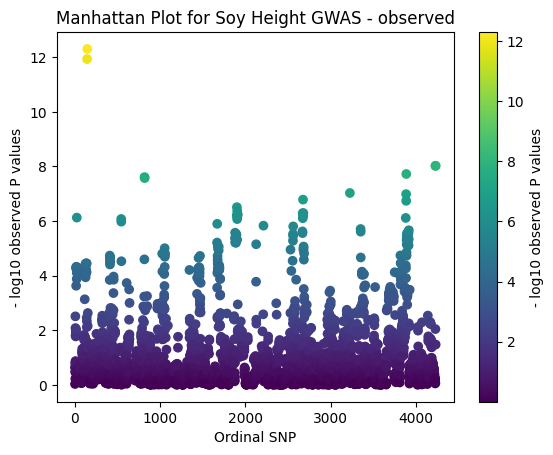

In [35]:

# mark in Kayle as pipeline step: Pipeline step: manhattan_known: Depends on: saliency_known 
model_folder = f"a-{time}-model"
p_values_observed_np = np.load('p_values_observed_np.npy',
                               allow_pickle=True)

neg_log = -1 * np.log10(p_values_observed_np)
slug = np.arange(p_values_observed_np.shape[0])

pt = plt.scatter(x = slug, y = neg_log, c=neg_log)
plt.title(f"Manhattan Plot for {experiment_description} - observed")
plt.xlabel("Ordinal SNP")
plt.ylabel("- log10 observed P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 observed P values")
plt.savefig(f"{model_folder}-manhattan-observed")


In [13]:


val_snps_s = np.load("val_snps_for_saliency.npy", allow_pickle=True)
model_folder = f"a-{time}-model"

def get_saved_model(final_activation_scale_factor: float, model_folder: str):
    final_model = tf.keras.models.load_model(model_folder)
    for layer in final_model.layers:
        layer.trainable=False
    return final_model
    # print(layer.weights)

final_model = get_saved_model(final_activation_scale_factor=final_activation_scale_factor, model_folder = model_folder)
val_phenotypes_p = final_model.predict(val_snps_s).flatten()

p_values_p = []
for i in np.arange(int(val_snps_s.shape[1] / 3)):
    column_index_lower_bound = 3 * i
    column_index_upper_bound = 3 * i + 3
    data = val_snps_s[:,column_index_lower_bound:column_index_upper_bound]
    data_reshaped = np.argmax(data, axis=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_reshaped, val_phenotypes_p)
    p_values_p.append(p_value)
p_values_predicted_np = np.array(p_values_p)
np.save('p_values_predicted_np', 
        p_values_predicted_np, 
        allow_pickle=True)


FileNotFoundError: [Errno 2] No such file or directory: 'val_snps_for_saliency.npy'

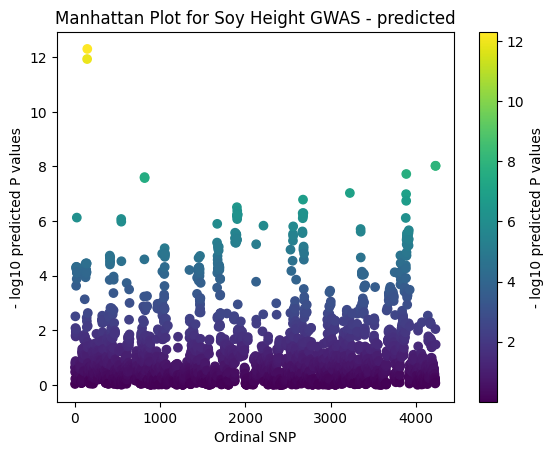

In [37]:

# mark in Kayle as pipeline step: Pipeline step: manhattan_known: Depends on: saliency_known 
model_folder = f"a-{time}-model"
p_values_predicted_np = np.load('p_values_predicted_np.npy',
                               allow_pickle=True)

neg_log = -1 * np.log10(p_values_predicted_np)
slug = np.arange(p_values_predicted_np.shape[0])

pt = plt.scatter(x = slug, y = neg_log, c=neg_log)
plt.title(f"Manhattan Plot for {experiment_description} - predicted")
plt.xlabel("Ordinal SNP")
plt.ylabel("- log10 predicted P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 predicted P values")
plt.savefig(f"{model_folder}-manhattan-predicted")


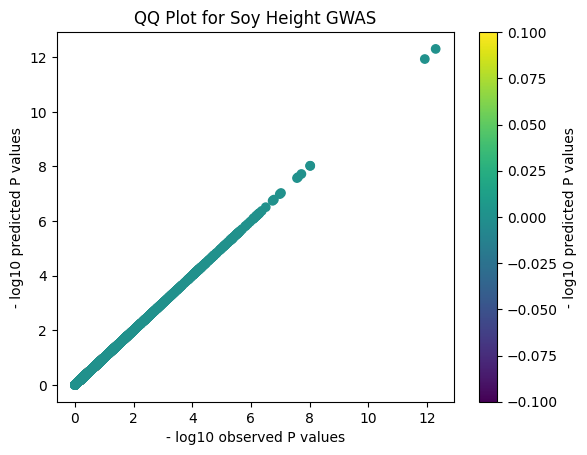

In [38]:

# mark in Kayle as pipeline step: qq plot

model_folder = f"a-{time}-model"

p_values_observed_np = np.load('p_values_observed_np.npy',
                               allow_pickle=True)

neg_log_o = -1 * np.log10(p_values_observed_np)


p_values_predicted_np = np.load('p_values_predicted_np.npy',
                               allow_pickle=True)

neg_log_p = -1 * np.log10(p_values_predicted_np)

pt = plt.scatter(x = neg_log_o, y = neg_log_p, c= neg_log_p - neg_log_o)
plt.title(f"QQ Plot for {experiment_description}")
plt.xlabel("- log10 observed P values")
plt.ylabel("- log10 predicted P values")
cbar = plt.colorbar(pt)
cbar.set_label("- log10 predicted P values - log10 observed")
plt.savefig(f"{model_folder}-manhattan-predicted")




## There is a second notebook to run after you run this pipeline. Please find the model folder for the best model that Katib found.


In [39]:

print(val_mean_absolute_error)


NameError: name 'val_mean_absolute_error' is not defined